In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sns
from pathlib import Path
import requests
import json



##--------MC SIMULATION REQUIREMENTS---------##

import os
import unittest
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from alpaca_trade_api import REST


alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


api = REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets"
)

In [2]:
alpha_api = 'GQ3V6KMM3ISFS1NB'

# global variables 
indexes = 'SPY QQQ IWM DIA'
sectors = 'IYC IYH IYK IYR IYZ XLB XLE XLF XLI XLK XLU'
index_plus_sectors = indexes + ' ' + sectors

optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

stocks_by_sector = pd.read_csv(Path('./Resources/stocks_by_sector.csv'), index_col='Ticker')

# dates
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()

date_list = [one_year, three_years_ago, five_years_ago, ten_years_ago, thirty_years_ago]
sqrt_252 = np.sqrt(252)

In [3]:
# method for getting close prices on a list of stocks
# important - don't put unnecessary spaces in the tickers, especially if it's a single ticker
def get_close(start, end, tickers = 'spy', interval = '1d'):
    
    if len(tickers) < 5:
        df = yf.Ticker(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']
        data = data.rename(tickers)
    else:
        df = yf.Tickers(tickers)
        data = df.history(start=start, end=end, interval = interval)
        data = data['Close']  
        
    data.index = data.index.date
    return data

# method for getting cumulative return on a stock from a series of close prices
def get_cumprod(series):
    series = series.pct_change()
    series = (series + 1).cumprod()
    series.dropna(inplace= True)
    return series

# get correlation matrix from multiple series
def get_corr(stocks = []):
    all_stocks = pd.concat(stocks, axis=1).dropna()
    all_stocks = all_stocks.corr()
    return all_stocks

# method for getting er dates
def get_er_range(stock, api_key, delta = 10):
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyEarnings'])
    df= pd.Series(df['reportedDate'])
    # convert the series to a datetime format
    dates = pd.to_datetime(df)
    # create an empty list to hold the new date ranges
    date_ranges = []
    # loop over each date in the series
    for date in dates:
        # create a date range for 10 days before and after the current date
        date_range = pd.date_range(date - pd.Timedelta(days=delta), date + pd.Timedelta(days=delta))
        # convert the date range to a Series object
        date_range_series = pd.Series(date_range)
        # add the date range to the list of date ranges
        date_ranges.append(date_range_series)
    # concatenate the list of date ranges into a single Series object
    new_dates = pd.concat(date_ranges)
    # remove any duplicates and sort the new series
    new_dates = pd.Series(sorted(set(new_dates)))
    # print the new series
    return new_dates


def get_income_statement(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

def get_balance_sheet(stock, api_key):
    url = f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={stock}&last=20&apikey={api_key}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['quarterlyReports'])
    return df

# returns a df that has cumulative return for a set period for holding a stock vs holding it during er window
def comp_er_window(ticker, start, end, api_key):

    pct = get_close(start = start, end = end, tickers = ticker).pct_change()
    _range = get_er_range(ticker, api_key)

    standard_final = (pct + 1).cumprod().iloc[-1]
    pct = pct.reset_index()


    er_window = pd.concat([_range, pct], axis = 1, join = 'inner').drop('index', axis = 1)
    er_window.set_index(er_window.columns[0], inplace= True)
    er_window.dropna(inplace= True)
    er_final = (er_window + 1).cumprod().iloc[-1].values.astype(float)

    out = pd.DataFrame({
        "Buy and hold": standard_final,
        "Buy During Earnings": er_final
    })
    return out

# get a series of total returns on a weighted portfolio
def portfolio_returns(tickers, weights, start, end):
    portfolio = get_cumprod(get_close(start=start, end = end, tickers = tickers))
    return portfolio.dot(weights)

def get_pctchge(series_pct):
    series_pct = series_pct.pct_change()
    series_pct.dropna(inplace=True)
    return series_pct

def get_mean(series):
    series_m = series.mean()
    series_m = series_m*252
    
    return series_m
    
def get_std(series):
    series_sd = series.std()
    series_sd = series_sd*np.sqrt(252)
    
    return series_sd

def get_sharpe(series_m, series_sd):
    series_sharpe = (series_m - 0.05) / series_sd
    
    return series_sharpe

def cum_ret_rank(df, i):
    sectors_1_cum = df.iloc[-1:]
    sectors_1_cum = sectors_1_cum.transpose()
    columns = ["Close"]
    sectors_1_cum.columns = columns
    sectors_1_cum["CumRet"] = (sectors_1_cum['Close'] - 1)*100
    sectors_1_cum = sectors_1_cum.sort_values('CumRet', ascending=False)
    sectors_1_cum = sectors_1_cum.drop('Close', axis=1)
    sectors_1_cum.index.rename('Index', inplace=True)

    sectors_1_cum = sectors_1_cum.rename(index={'DIA': 'Dow Ind',
                                                'IWM': 'Russell',
                                                'IYC': 'Cons Disc',
                                                'IYH': 'Healthcare',
                                                'IYK': 'Cons Stple',
                                                'IYR': 'Real Est.',
                                                'IYZ': 'Comm',
                                                'QQQ': 'NASDAQ',
                                                'SPY': 'S&P 500',
                                                'XLB': 'Materials',
                                                'XLE': 'Energy',
                                                'XLF': 'Financials',
                                                'XLI': 'Industrials',
                                                'XLK': 'Technology',
                                                'XLU': 'Utilities'})


    sectors_1_bchart = sectors_1_cum.hvplot.bar(xlabel='Index', ylabel='CumRet', hover_color='red', height=500, width=1000).opts(
        yformatter='%.0f', title=f'Index and Sector Cumulative Returns Ranking - {i} Year Window')
    return  sectors_1_bchart

def get_metrics(df):
    ind_sec_1y = get_pctchge(df)
    ind_sec_1y_m = get_mean(ind_sec_1y)
    ind_sec_1y_sd = get_std(ind_sec_1y)
    ind_sec_1y_sr = get_sharpe(ind_sec_1y_m, ind_sec_1y_sd)

    ind_sec_1y_m = ind_sec_1y_m.sort_values(ascending=False)
    ind_sec_1y_sd = ind_sec_1y_sd.sort_values(ascending=False)
    ind_sec_1y_sr = ind_sec_1y_sr.sort_values(ascending=False)
    return ind_sec_1y_m, ind_sec_1y_sd, ind_sec_1y_sr

In [4]:
sectors_10_daily = get_close(ten_years_ago, yesterday, tickers = index_plus_sectors)
sectors_5_daily = get_close(five_years_ago, yesterday, tickers = index_plus_sectors)
sectors_1_daily = get_close(one_year, yesterday, tickers = index_plus_sectors)

sectors_10 = get_cumprod(sectors_10_daily)
sectors_5 = get_cumprod(sectors_5_daily)
sectors_1 = get_cumprod(sectors_1_daily)

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


In [5]:
ind_sec_1y_m, ind_sec_1y_sd, ind_sec_1y_sr = get_metrics(sectors_1_daily)

In [6]:
ind_sec_5y_m, ind_sec_5y_sd, ind_sec_5y_sr = get_metrics(sectors_5_daily)

In [7]:
ind_sec_10y_m, ind_sec_10y_sd, ind_sec_10y_sr = get_metrics(sectors_10_daily)

In [8]:
ind_sec_1y_df = pd.concat([ind_sec_1y_m,  ind_sec_1y_sd, ind_sec_1y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_1y_df.columns = columns

In [9]:
ind_sec_5y_df = pd.concat([ind_sec_5y_m,  ind_sec_5y_sd, ind_sec_5y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_5y_df.columns = columns

In [10]:
ind_sec_10y_df = pd.concat([ind_sec_10y_m,  ind_sec_10y_sd, ind_sec_10y_sr], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio"]
ind_sec_10y_df.columns = columns

In [11]:
ind_sec_1y_df.hvplot.scatter(x='Std Dev', y='Mean', hover_color='Ticker',
                  legend='right', height=500, width=1000, title='Mean and Standard Deviation 1-Year View of Index & Sector Returns')

:Scatter   [Std Dev]   (Mean)

In [12]:
ind_sec_5y_df.hvplot.scatter(x='Std Dev', y='Mean', hover_color='Ticker',
                  legend='right', height=500, width=1000, title='Mean and Standard Deviation 5-Year View of Index & Sector Returns')

:Scatter   [Std Dev]   (Mean)

In [13]:
ind_sec_10y_df.hvplot.scatter(x='Std Dev', y='Mean', hover_color='Ticker',
                  legend='right', height=500, width=1000, title='Mean and Standard Deviation 10-Year View of Index & Sector Returns')

:Scatter   [Std Dev]   (Mean)

In [14]:
sectors_1.hvplot().opts(height = 400,
                     width = 1000, title = 'Cumulative Returns for Index & Sectors - 1-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [15]:
sectors_5.hvplot().opts(height = 400,
                     width = 1000, title = 'Cumulative Returns for Index & Sectors - 5-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [16]:
sectors_10.hvplot().opts(height = 400,
                     width = 1000, title = 'Cumulative Returns for Index & Sectors - 10-year View')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [17]:
cum_ret_rank(sectors_1, 1)

:Bars   [Index]   (CumRet)

In [18]:
cum_ret_rank(sectors_5, 5)

:Bars   [Index]   (CumRet)

In [19]:
cum_ret_rank(sectors_10, 10)

:Bars   [Index]   (CumRet)

In [20]:
stock_prices = get_close(one_year, yesterday, optionable_stocks)

stk_ret_1y_m, stk_ret_1y_sd , stk_ret_1y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [21]:
stock_prices = get_close(five_years_ago, yesterday, optionable_stocks)
stk_ret_5y_m, stk_ret_5y_sd , stk_ret_5y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [22]:
stock_prices = get_close(ten_years_ago, yesterday, optionable_stocks)
stk_ret_10y_m, stk_ret_10y_sd , stk_ret_10y_sr = get_metrics(stock_prices)

[*********************100%***********************]  95 of 95 completed


In [23]:
stk_analysis_1y_df = pd.concat([stk_ret_1y_m,  stk_ret_1y_sd, stk_ret_1y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_1y_df.columns = columns

In [24]:
stk_analysis_5y_df = pd.concat([stk_ret_5y_m,  stk_ret_5y_sd, stk_ret_5y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_5y_df.columns = columns

In [25]:
stk_analysis_10y_df = pd.concat([stk_ret_10y_m,  stk_ret_10y_sd, stk_ret_10y_sr, stocks_by_sector], axis="columns", join="inner")
columns = ["Mean", "Std Dev", "Sharpe Ratio", "Sector"]
stk_analysis_10y_df.columns = columns

In [26]:
stk_analysis_1y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 1-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'])

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

In [27]:
stk_analysis_5y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 5-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'])

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

In [28]:
stk_analysis_10y_df.hvplot.scatter(x='Std Dev', y='Mean', color = 'Sharpe Ratio', hover_color='Ticker',
                                  legend='right', height=500, width=1000,
                                  title='Mean and Standard Deviation 10-Year View of Optionable Stock Universe',
                                  hover_cols=['index','Sector'])

:Scatter   [Std Dev]   (Mean,Sharpe Ratio,index,Sector)

In [29]:
sectors_corr_10 = sectors_10.corr()
sectors_corr_5 = sectors_5.corr()
sectors_corr_1 = sectors_1.corr()

<AxesSubplot:>

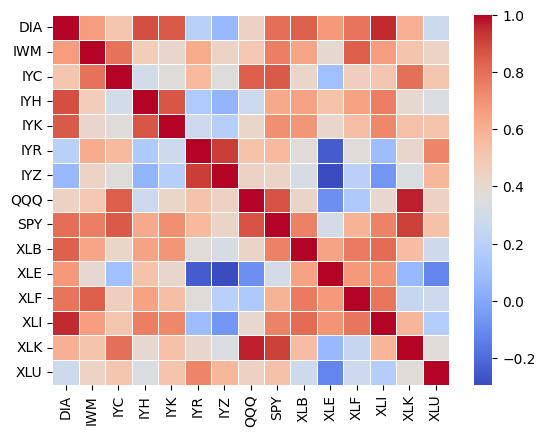

In [30]:
sns.heatmap(sectors_corr_1, cmap = 'coolwarm', linewidth = 0.5)

<AxesSubplot:>

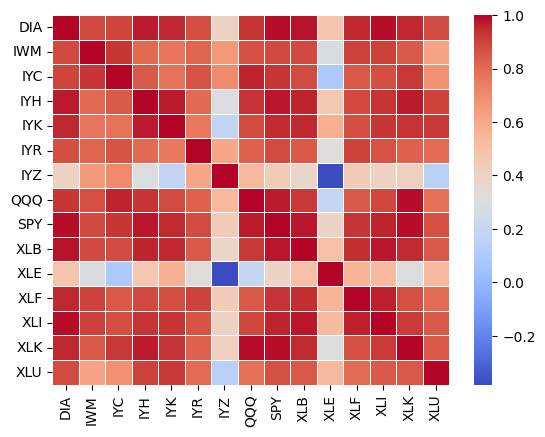

In [31]:
sns.heatmap(sectors_corr_5, cmap = 'coolwarm', linewidth = 0.5)

<AxesSubplot:>

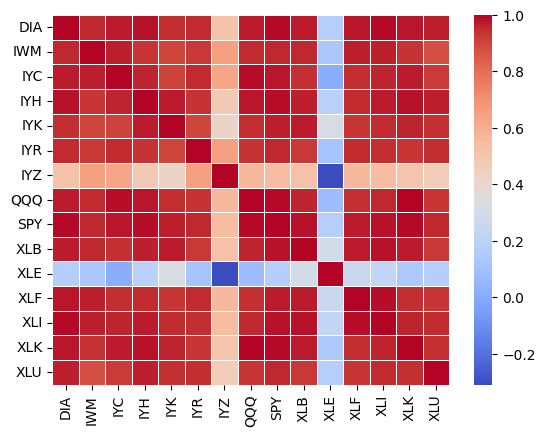

In [32]:
sns.heatmap(sectors_corr_10, cmap = 'coolwarm', linewidth = 0.5)

In [33]:
stk_analysis_1y_shr = stk_analysis_1y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_1y_shr_h = stk_analysis_1y_shr.head(10)
stk_analysis_1y = stk_analysis_1y_shr_h.hvplot.bar(xlabel='Stock', ylabel='Sharpe Ratio', ylim=(-3, 3), height=500, width=1000).opts(
    yformatter='%.0f', title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 1 Year Window')
stk_analysis_1y

:Bars   [index]   (Sharpe Ratio)

In [34]:
stk_analysis_5y_shr = stk_analysis_5y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_5y_shr_h = stk_analysis_5y_shr.head(10)
stk_analysis_5y = stk_analysis_5y_shr_h.hvplot.bar(xlabel='Stock', ylabel='Sharpe Ratio', ylim=(-3, 3), height=500, width=1000).opts(
    yformatter='%.0f', title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 5 Year Window')
stk_analysis_5y

:Bars   [index]   (Sharpe Ratio)

In [35]:
stk_analysis_10y_shr = stk_analysis_10y_df['Sharpe Ratio'].sort_values(ascending=False)
stk_analysis_10y_shr_h = stk_analysis_10y_shr.head(10)
stk_analysis_10y = stk_analysis_10y_shr_h.hvplot.bar(xlabel='Stock', ylabel='Sharpe Ratio', ylim=(-3, 3), height=500, width=1000).opts(
    yformatter='%.0f', title='Top 10 Sharpe Ratio Optionable Stocks Ranking - 10 Year Window')
stk_analysis_10y

:Bars   [index]   (Sharpe Ratio)

In [5]:
###-----------------MC SIMULATION-----------------###

# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
# YOUR CODE HERE!

df_ticker = api.get_bars(tickers, timeframe, start=start_date, end=end_date, limit=10000).df
# Display sample data
df_ticker.head()

open   high    low  close    volume  trade_count  \
timestamp                                                                      
2017-05-01 04:00:00+00:00  55.43  55.45  54.98  54.99   4881442        30491   
2017-05-02 04:00:00+00:00  55.12  55.16  54.79  55.07   7363885        41589   
2017-05-03 04:00:00+00:00  55.17  55.30  54.40  54.53   9486619        48477   
2017-05-04 04:00:00+00:00  54.68  54.83  54.20  54.47   6830628        39260   
2017-05-05 04:00:00+00:00  54.41  54.50  53.56  53.95  13379949        57959   

                                vwap symbol  
timestamp                                    
2017-05-01 04:00:00+00:00  55.201737    NKE  
2017-05-02 04:00:00+00:00  54.967165    NKE  
2017-05-03 04:00:00+00:00  54.622933    NKE  
2017-05-04 04:00:00+00:00  54.501544    NKE  
2017-05-05 04:00:00+00:00  53.889567    NKE

In [6]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!

MC_even_dist = MCSimulation(
    
    portfolio_data=df_ticker,
    weights=[0.33, 0.33, 0.33],
    num_simulation=1000,
    num_trading_days=252*5
)


# Print the simulation input data
MC_even_dist.portfolio_data.head()

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!
MCSimulation.plot_simulation(MC_even_dist)